# <p style="font-family: 'Amiri'; font-size: 2rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #deadb2; padding: 30px; border-radius: 20px; border: 8px solid black; width:90%">˚PS4E11 | Mental Health Data | CatBoost˚</p>

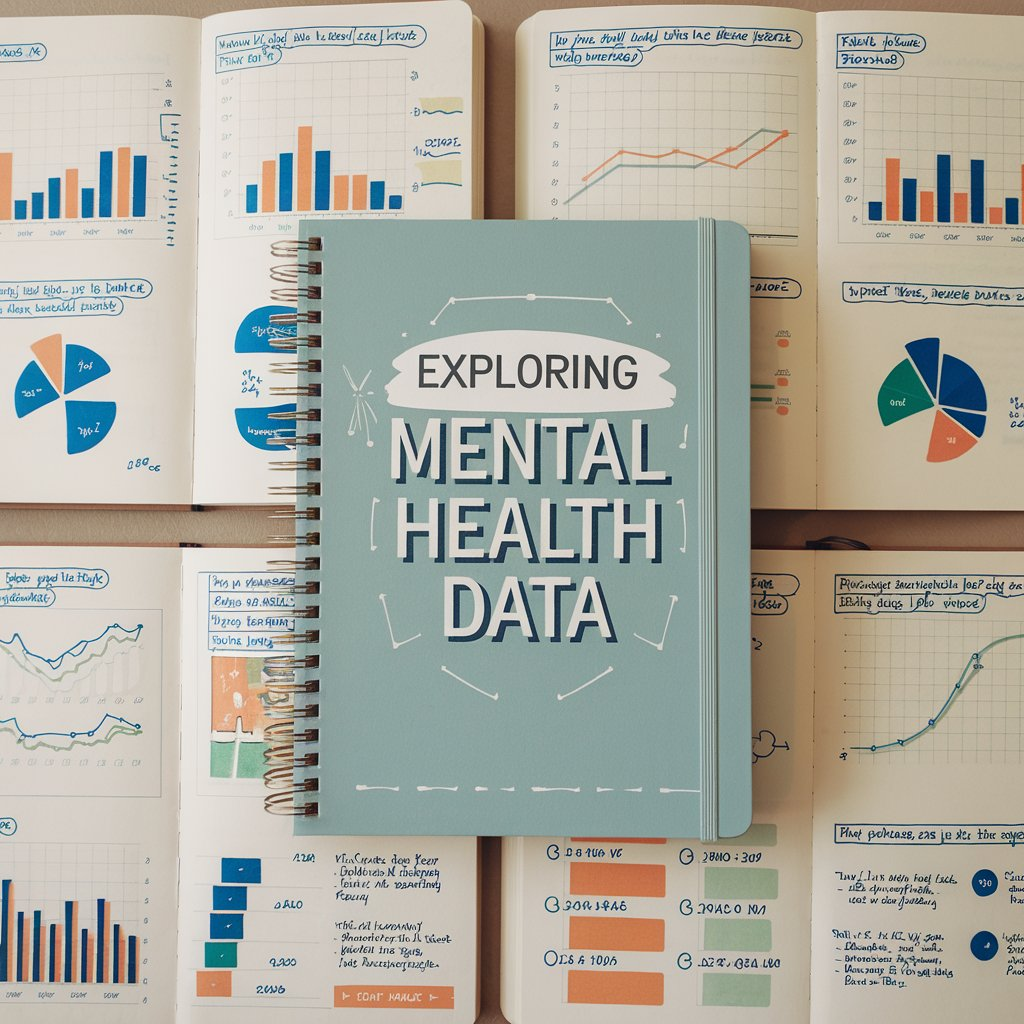

# <p style="font-family: 'Amiri'; font-size: 2rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #deadb2; padding: 10px; border-radius: 20px; border: 8px solid black; width:90%">Import Dependencies</p>

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from colorama import Fore, Style, init;
from IPython.display import display, HTML

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler , StandardScaler , QuantileTransformer, PowerTransformer
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.metrics import *
pd.set_option('display.max_columns', None)

# <p style="font-family: 'Amiri'; font-size: 2rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #deadb2; padding: 10px; border-radius: 20px; border: 8px solid black; width:90%">Load Train and Test Data</p>

In [2]:
# Load training and testing datasets
# Load and index the train dataset
tr_ds = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
tr_ds.set_index('id', inplace=True)

# Load the original dataset and convert 'Depression' values to binary
original = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')
original['Depression'] = original['Depression'].apply(lambda x: 1 if x == 'Yes' else 0)

# Concatenate both datasets along rows
tr_ds = pd.concat([tr_ds, original], axis=0)

# Load and index the test dataset
te_ds = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')
te_ds.set_index('id', inplace=True)

# Load the sample_submission dataset
submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')

# <p style="font-family: 'Amiri'; font-size: 2rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #deadb2; padding: 10px; border-radius: 20px; border: 8px solid black; width:90%">Dealing with Missing Values</p>

In [ ]:
tr_ds = tr_ds.fillna('None').astype('string')
te_ds = te_ds.fillna('None').astype('string')

# <p style="font-family: 'Amiri'; font-size: 2rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #deadb2; padding: 10px; border-radius: 20px; border: 8px solid black; width:90%">Basic Overview</p>

In [14]:
def styled_heading(text, background_color='#deadb2', text_color='black'):
    return f"""
    <div style="
        text-align: center;
        background: {background_color};
        font-family: 'Montserrat', sans-serif;
        color: {text_color};
        padding: 15px;
        font-size: 30px;
        font-weight: bold;
        line-height: 1;
        border-radius: 20px 20px 0 0;
        margin: 20px 0;  /* Added margin for spacing */
        box-shadow: 0px 4px 6px rgba(0, 0, 0, 0.2);
        border: 3px dashed {text_color};
    ">
        {text}
    </div>
    """

def D_O(train_df, heading_bg='lightblue', heading_color='black', text_bg='white', text_color='black'):
    try:
        # Display head and tail of the training dataset nicely
        for heading, df_part in zip(
            ["The Head Of Dataset is:", "The Tail Of Dataset is:", "Numerical Summary of Data:"], 
            [train_df.head(5), train_df.tail(5), train_df.describe()]
        ):
            display(HTML(styled_heading(heading, background_color=heading_bg, text_color=heading_color)))
            display(HTML(df_part.to_html(index=False).replace(
                '<table border="1" class="dataframe">', 
                f'<table style="border: 8px solid black; margin-bottom: 20px; background-color: {text_bg}; color: {text_color};">'
            ).replace('<td>', f'<td style="color: {text_color}; background-color: {text_bg};">')))
            print("\n")  

        # Print shape data
        display(HTML(styled_heading("Shape Data:", background_color=heading_bg, text_color=heading_color)))
        print(f'Shape of the Data: {train_df.shape}')
        print(f'Rows: {train_df.shape[0]}')
        print(f'Columns: {train_df.shape[1]}')
        print("\n<br>\n")  

        # Print info of train data
        display(HTML(styled_heading("Info Of Data:", background_color=heading_bg, text_color=heading_color)))
        buffer = StringIO()
        train_df.info(buf=buffer)
        buffer.seek(0)
        info_str = buffer.read()
        display(HTML(f"<pre style='color: {text_color}; background-color: {text_bg}; margin-bottom: 20px; font-family: Courier, monospace; font-size: 14px; padding: 10px; border: 8px solid black;'>{info_str}</pre>"))
        print("\n<br>\n")  # Adding space between sections

        # Print categorical columns
        Cat_cols_train = [col for col in train_df.columns if train_df[col].dtype == 'O']
        display(HTML(styled_heading("Categorical Columns of Data:", background_color=heading_bg, text_color=heading_color)))
        print(f'The Categorical Columns of Data are: {Cat_cols_train}')
        print("\n<br>\n")  # Adding space between sections

        # Print numerical columns
        N_cols_train = [col for col in train_df.columns if train_df[col].dtype == 'float']
        display(HTML(styled_heading("Numerical Columns of Data:", background_color=heading_bg, text_color=heading_color)))
        print(f'The Numerical Columns of Data are: {N_cols_train}')
        print("\n<br>\n")  # Adding space between sections

        # Print null values
        display(HTML(styled_heading("Null Values in Data:", background_color=heading_bg, text_color=heading_color)))
        null_values = train_df.isnull().sum()
        display(HTML(f"<pre style='color: {text_color}; background-color: {text_bg}; margin-bottom: 20px; font-family: Courier, monospace; font-size: 14px; padding: 10px; border: 8px solid black;'>{null_values}</pre>"))
        print("\n<br>\n")  
        
        # Print duplicates check
        display(HTML(styled_heading("Duplicates Check in Data:", background_color=heading_bg, text_color=heading_color)))
        if train_df.duplicated().any():
            print(f'Duplicates exist in the dataset.')
        else:
            print(f'No duplicates found in the dataset.')
        print("\n<br>\n")  

    except Exception as e:
        print_error(str(e))

In [16]:
# Import Basis
import pandas as pd 
import optuna
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import seaborn as sns 
import math
from io import StringIO
from colorama import Fore, Style, init;
# Import necessary libraries
from IPython.core.display import display, HTML
from scipy.stats import skew  
# Import Plotly.go
import plotly.graph_objects as go
# import Subplots
from plotly.subplots import make_subplots
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder, MinMaxScaler , StandardScaler , QuantileTransformer
from sklearn.impute import SimpleImputer

# Paellete
palette = ['Black', '#b379ed']
color_palette = sns.color_palette(palette)

# Set the option to display all columns
pd.set_option('display.max_columns', None)

# <p style="font-family: 'Amiri'; font-size: 2rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #deadb2; padding: 20px; border-radius: 20px; border: 8px solid black; width:30%">Train Data</p>

In [17]:
D_O(tr_ds, heading_bg='#deadb2', heading_color='black', text_bg='#deadb2', text_color='black')

Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,None,5.0,None,None,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
Vivan,Male,26.0,Varanasi,Working Professional,Teacher,None,4.0,None,None,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
Yuvraj,Male,33.0,Visakhapatnam,Student,None,5.0,None,8.97,2.0,None,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,None,5.0,None,None,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,None,1.0,None,None,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
Raghavendra,Male,25.0,Bangalore,Working Professional,Consultant,None,1.0,None,None,5.0,5-6 hours,Healthy,BBA,Yes,12.0,3.0,Yes,0
Pihu,Female,23.0,Pune,Working Professional,Teacher,None,3.0,None,None,1.0,Less than 5 hours,Moderate,MA,Yes,8.0,3.0,No,1
Sara,Female,24.0,Srinagar,Working Professional,HR Manager,None,1.0,None,None,4.0,Less than 5 hours,Moderate,BA,Yes,4.0,4.0,No,0
Eshita,Female,56.0,Bangalore,Working Professional,Business Analyst,None,2.0,None,None,3.0,7-8 hours,Healthy,BBA,No,4.0,5.0,Yes,0
Kiran,Male,18.0,Surat,Student,None,5.0,None,6.7,3.0,None,More than 8 hours,Unhealthy,Class 12,No,6.0,2.0,Yes,1


Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
143256,143256,143256,143256,143256,143256,143256,143256,143256,143256,143256,143256,143256,143256,143256,143256,143256,143256,143256
422,2,43,98,2,65,6,6,332,6,6,36,24,116,2,13,6,2,2
Rohan,Male,56.0,Kalyan,Working Professional,None,None,None,None,None,None,Less than 5 hours,Moderate,Class 12,No,10.0,2.0,No,0
3204,78797,5319,6683,114853,37303,114857,28420,114856,114857,28412,39432,50537,15004,72445,14417,32000,72069,117234


Shape of the Data: (143256, 19)
Rows: 143256
Columns: 19

<br>




<br>



The Categorical Columns of Data are: []

<br>



The Numerical Columns of Data are: []

<br>




<br>



No duplicates found in the dataset.

<br>



# <p style="font-family: 'Amiri'; font-size: 2rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #deadb2; padding: 20px; border-radius: 20px; border: 8px solid black; width:30%">Test Data</p>

In [18]:
D_O(te_ds, heading_bg='#deadb2', heading_color='black', text_bg='#deadb2', text_color='black')

Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,None,2.0,None,None,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,None,2.0,None,None,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
Yash,Male,53.0,Jaipur,Working Professional,Teacher,None,4.0,None,None,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
Nalini,Female,23.0,Rajkot,Student,None,5.0,None,6.84,1.0,None,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,None,5.0,None,None,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No


Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
Zoya,Female,49.0,Jaipur,Working Professional,Pilot,None,3.0,None,None,5.0,Less than 5 hours,Moderate,BSc,Yes,2.0,2.0,Yes
Shlok,Male,29.0,Ahmedabad,Working Professional,Pilot,None,5.0,None,None,1.0,7-8 hours,Moderate,BE,Yes,11.0,3.0,Yes
Rishi,Male,24.0,Visakhapatnam,Student,None,1.0,None,7.51,4.0,None,7-8 hours,Moderate,B.Tech,No,7.0,1.0,No
Eshita,Female,23.0,Kalyan,Working Professional,Marketing Manager,None,4.0,None,None,2.0,5-6 hours,Healthy,BA,Yes,7.0,5.0,Yes
Gauri,Female,43.0,Varanasi,Working Professional,Educational Consultant,None,5.0,None,None,2.0,More than 8 hours,Healthy,B.Ed,No,11.0,2.0,No


Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
93800,93800,93800,93800,93800,93800,93800,93800,93800,93800,93800,93800,93800,93800,93800,93800,93800,93800
374,2,44,68,2,65,6,6,327,6,6,31,23,88,2,13,5,2
Rohan,Male,56.0,Kalyan,Working Professional,None,None,None,None,None,None,Less than 5 hours,Moderate,Class 12,No,10.0,2.0,No
2112,51262,3432,4387,75028,24632,75033,18778,75034,75033,18774,25661,33018,9812,47375,9450,21151,47118


Shape of the Data: (93800, 18)
Rows: 93800
Columns: 18

<br>




<br>



The Categorical Columns of Data are: []

<br>



The Numerical Columns of Data are: []

<br>




<br>



No duplicates found in the dataset.

<br>



# <p style="font-family: 'Amiri'; font-size: 2rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #deadb2; padding: 10px; border-radius: 20px; border: 8px solid black; width:90%">Model Building</p>

In [9]:
# =====================================
# | X | Y | of | Train | Data: |
# =====================================
X = tr_ds.drop('Depression', axis=1)
y = tr_ds['Depression']

# =====================================
# | Train | Test | Split |  | Data: |
# =====================================
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size=0.1, random_state=42)

# =====================================
# | Shapes |
# =====================================
print(f"Training set shape - X: {X_Train.shape}, y: {Y_Train.shape}")
print(f"Testing set shape - X: {X_Test.shape}, y: {Y_Test.shape}")

Training set shape - X: (128930, 18), y: (128930,)
Testing set shape - X: (14326, 18), y: (14326,)


In [11]:

# Define the modified training function
def train_ml_model(model, X, y, cat_features, n_splits=N_SPLITS, seed=SEED):
    """
    Trains a model with Stratified K-Fold cross-validation and evaluates using accuracy score.

    Parameters:
    model: The machine learning model to train.
    X: The feature matrix.
    y: The target vector.
    cat_features: List of categorical feature column indices for CatBoost.
    n_splits: Number of splits for cross-validation.
    seed: Random seed for reproducibility.

    Returns:
    model: The trained model.
    train_scores: List of accuracy scores for the training sets.
    val_scores: List of accuracy scores for the validation sets.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    train_scores = []
    val_scores = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        # Split data
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit model with early stopping
        model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val), 
                  verbose=0, early_stopping_rounds=50)

        # Predictions and scoring
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)

        # Store scores
        train_scores.append(train_acc)
        val_scores.append(val_acc)

        # Print fold scores
        print(f"Fold {fold}: Train Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}")

    # Mean accuracy scores
    mean_train_acc = np.mean(train_scores)
    mean_val_acc = np.mean(val_scores)

    print(f"\nMean Train Accuracy: {mean_train_acc:.4f}")
    print(f"Mean Validation Accuracy: {mean_val_acc:.4f}")

    return model, train_scores, val_scores

# Initialize CatBoost model with optimized parameters
model = CatBoostClassifier(
    random_seed=SEED, 
    verbose=0, 
    depth=6,  
    learning_rate=0.1,  
    iterations=785  
)

# Train model
trained_model, train_scores, val_scores = train_ml_model(model, X, y, cat_features=cat_features)

Fold 1: Train Accuracy = 0.9447, Validation Accuracy = 0.9412
Fold 2: Train Accuracy = 0.9470, Validation Accuracy = 0.9390
Fold 3: Train Accuracy = 0.9447, Validation Accuracy = 0.9421
Fold 4: Train Accuracy = 0.9436, Validation Accuracy = 0.9407
Fold 5: Train Accuracy = 0.9446, Validation Accuracy = 0.9373
Fold 6: Train Accuracy = 0.9447, Validation Accuracy = 0.9435
Fold 7: Train Accuracy = 0.9457, Validation Accuracy = 0.9380
Fold 8: Train Accuracy = 0.9458, Validation Accuracy = 0.9363
Fold 9: Train Accuracy = 0.9468, Validation Accuracy = 0.9446
Fold 10: Train Accuracy = 0.9464, Validation Accuracy = 0.9468
Fold 11: Train Accuracy = 0.9474, Validation Accuracy = 0.9456
Fold 12: Train Accuracy = 0.9459, Validation Accuracy = 0.9341
Fold 13: Train Accuracy = 0.9451, Validation Accuracy = 0.9426
Fold 14: Train Accuracy = 0.9451, Validation Accuracy = 0.9389
Fold 15: Train Accuracy = 0.9462, Validation Accuracy = 0.9359
Fold 16: Train Accuracy = 0.9447, Validation Accuracy = 0.9382
F

# <p style="font-family: 'Amiri'; font-size: 2rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #deadb2; padding: 10px; border-radius: 20px; border: 8px solid black; width:90%">Submission</p>

In [13]:
# Predict on test data
test_pred = trained_model.predict(te_ds)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': submission.id,
    'Depression': test_pred
})

# Save submission to CSV
submission.to_csv('submission.csv', index=False)

# <p style="font-family: 'Amiri'; font-size: 2rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #deadb2; padding: 10px; border-radius: 20px; border: 8px solid black; width:90%">Thank you</p>